In [1]:
!pip install kaggle
!mkdir -p /root/.kaggle
!scp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d akshat0007/fetalhr
!unzip fetalhr.zip -d fetalhr_data

Dataset URL: https://www.kaggle.com/datasets/akshat0007/fetalhr
License(s): DbCL-1.0
  0% 0.00/61.1k [00:00<?, ?B/s]
100% 61.1k/61.1k [00:00<00:00, 60.7MB/s]
Archive:  fetalhr.zip
  inflating: fetalhr_data/CTG.csv    


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [22]:
# Загрузка данных
df = pd.read_csv("fetalhr_data/CTG.csv")

print('CTG before cleansing:\n')
# Чекаем инфу
df.info()
display(df.head())
print(df.columns)
df.isna().sum()


CTG before cleansing:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  2126 non-null   object 
 1   Date      2126 non-null   object 
 2   SegFile   2126 non-null   object 
 3   b         2126 non-null   float64
 4   e         2126 non-null   float64
 5   LBE       2126 non-null   float64
 6   LB        2126 non-null   float64
 7   AC        2126 non-null   float64
 8   FM        2127 non-null   float64
 9   UC        2127 non-null   float64
 10  ASTV      2127 non-null   float64
 11  MSTV      2127 non-null   float64
 12  ALTV      2127 non-null   float64
 13  MLTV      2127 non-null   float64
 14  DL        2128 non-null   float64
 15  DS        2128 non-null   float64
 16  DP        2128 non-null   float64
 17  DR        2128 non-null   float64
 18  Width     2126 non-null   float64
 19  Min       2126 non-null   float64
 20  Max    

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


Index(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC',
       'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP',
       'CLASS', 'NSP'],
      dtype='object')


,0
FileName,3
Date,3
SegFile,3
b,3
e,3
LBE,3
LB,3
AC,3
FM,2
UC,2


In [23]:
print('\nCTG after cleansing:\n')
# Убираем лишние колонки и чекаем инфу и пустые данные
df = df.drop(['FileName','Date','SegFile', 'b', 'e', 'CLASS','A','B','C','D','E','AD','DE','LD','FS','SUSP'],axis=1)
for i in df.columns:
    a=np.mean(df[i])
    df[i]=df[i].fillna(a)
#df = df.dropna()
df=df.drop_duplicates()
df.info()
display(df.head())
print(df.columns)
df.isna().sum()


CTG after cleansing:

<class 'pandas.core.frame.DataFrame'>
Index: 2115 entries, 0 to 2128
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2115 non-null   float64
 1   LB        2115 non-null   float64
 2   AC        2115 non-null   float64
 3   FM        2115 non-null   float64
 4   UC        2115 non-null   float64
 5   ASTV      2115 non-null   float64
 6   MSTV      2115 non-null   float64
 7   ALTV      2115 non-null   float64
 8   MLTV      2115 non-null   float64
 9   DL        2115 non-null   float64
 10  DS        2115 non-null   float64
 11  DP        2115 non-null   float64
 12  DR        2115 non-null   float64
 13  Width     2115 non-null   float64
 14  Min       2115 non-null   float64
 15  Max       2115 non-null   float64
 16  Nmax      2115 non-null   float64
 17  Nzeros    2115 non-null   float64
 18  Mode      2115 non-null   float64
 19  Mean      2115 non-null   float64
 20  Median    21

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')


,0
LBE,0
LB,0
AC,0
FM,0
UC,0
ASTV,0
MSTV,0
ALTV,0
MLTV,0
DL,0


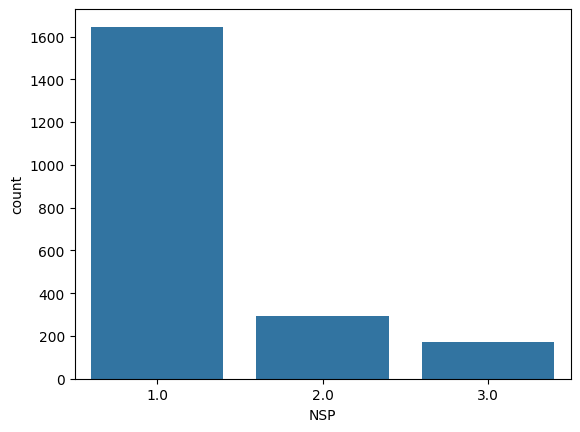

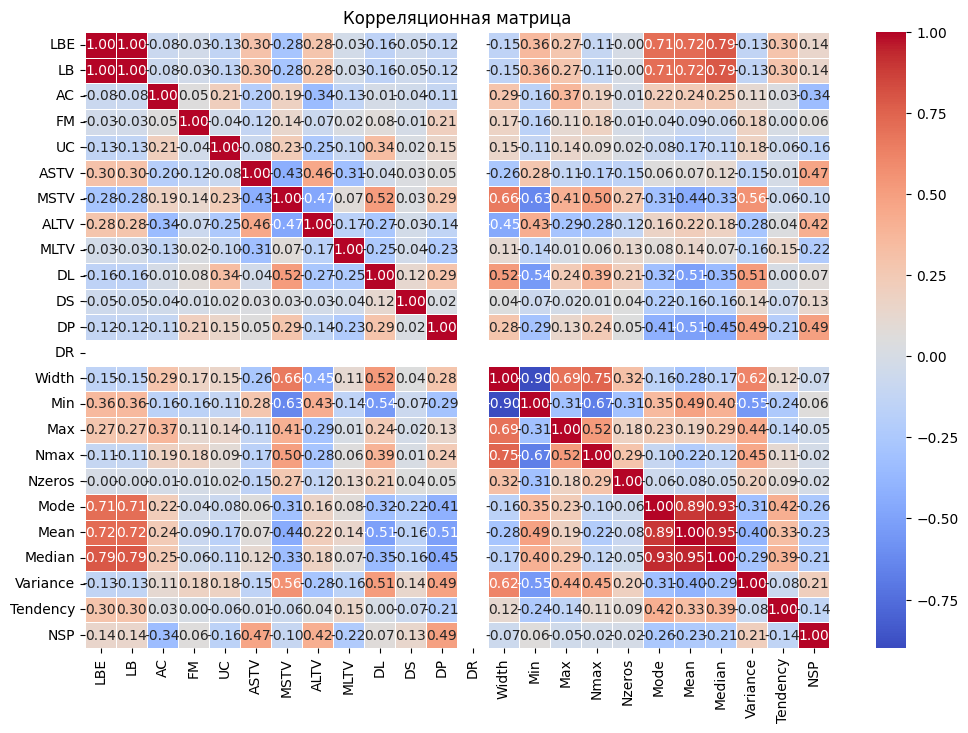

Наиболее значимые признаки:
NSP         1.000000
DP          0.493800
ASTV        0.468465
ALTV        0.418722
Variance    0.209422
UC         -0.162161
Median     -0.209919
MLTV       -0.224893
Mean       -0.231916
Mode       -0.255109
AC         -0.340038
Name: NSP, dtype: float64


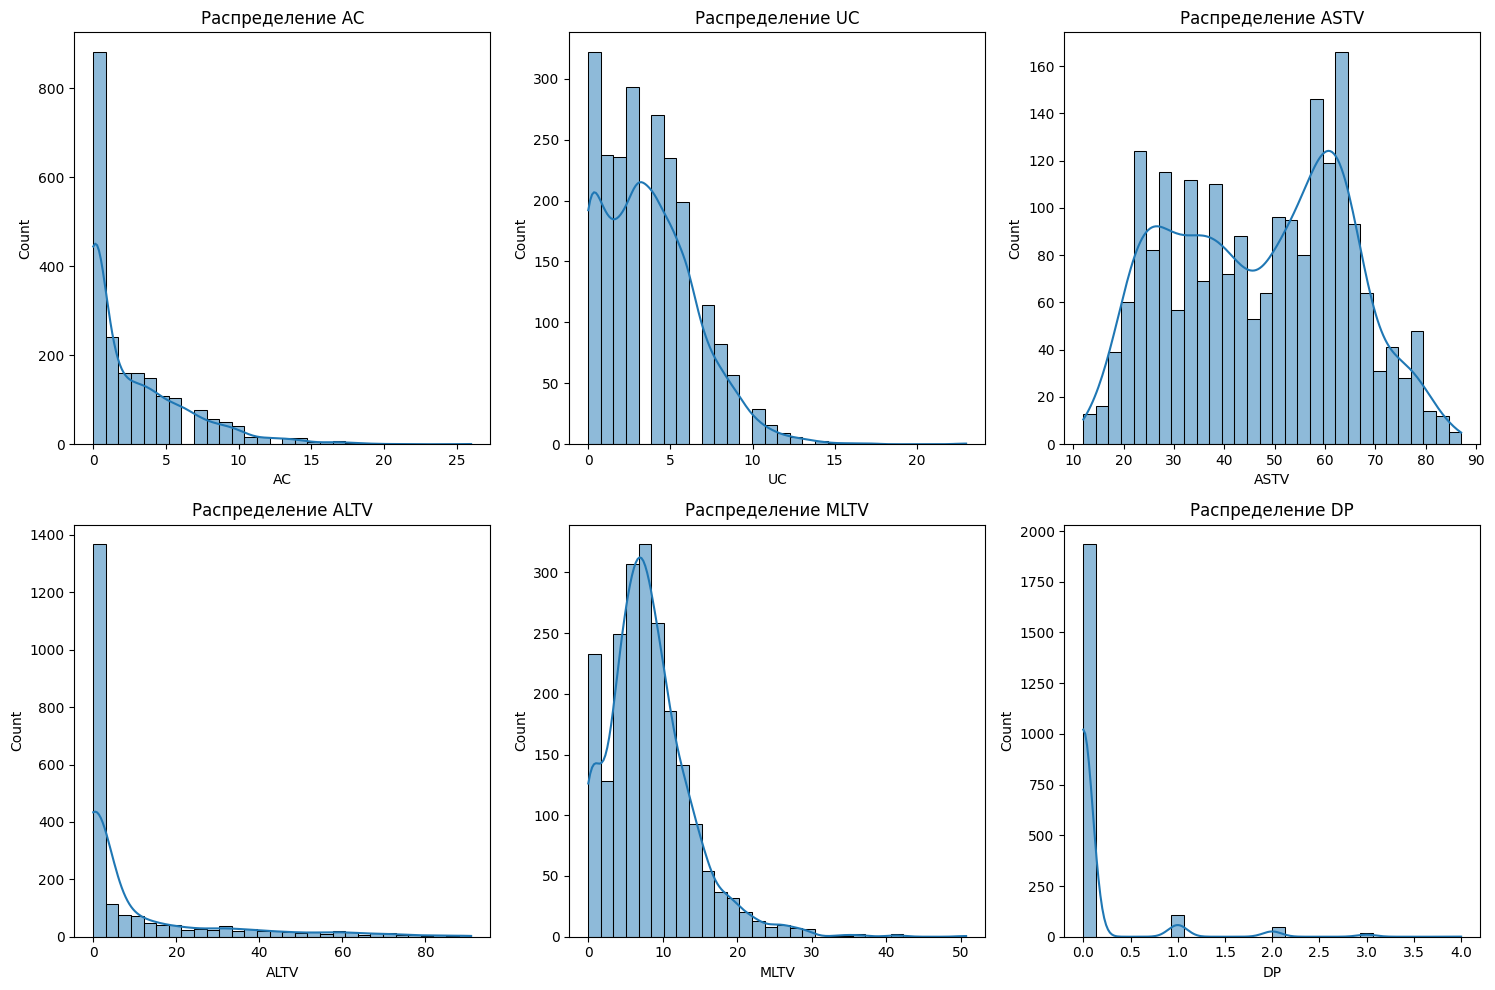

"\n# Коробчатые диаграммы распределения по классам\nplt.figure(figsize=(15, 10))\nfor i, feature in enumerate(selected_features[:6]):\n    plt.subplot(2, 3, i + 1)\n    sns.boxplot(x=df['NSP'], y=df[feature])\n    plt.title(f'Распределение {feature} по классам')\nplt.tight_layout()\nplt.show()\n"

In [24]:
# избавляемся от шума в NSP
df = df[df['NSP'].isin([1, 2, 3])]

# Визуализация количества классов
sns.countplot(data=df, x='NSP')
plt.show()

# Анализ корреляции признаков
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

# Выбор наиболее коррелированных с целевой переменной признаков
correlation_threshold = 0.15  # Порог значимости корреляции
correlated_features = corr_matrix['NSP'][abs(corr_matrix['NSP']) > correlation_threshold]
print("Наиболее значимые признаки:")
print(correlated_features.sort_values(ascending=False))

# Визуализация распределений признаков
selected_features = correlated_features.index.tolist()
selected_features.remove('NSP')  # Исключаем целевую переменную

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features[:6]):  # 6 признаков
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

'''
# Коробчатые диаграммы распределения по классам
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df['NSP'], y=df[feature])
    plt.title(f'Распределение {feature} по классам')
plt.tight_layout()
plt.show()
'''

Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DS', 'DP', 'DR', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency',
       'NSP'],
      dtype='object')
(2112, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 2112 entries, 0 to 2125
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2112 non-null   float64
 1   LB        2112 non-null   float64
 2   AC        2112 non-null   float64
 3   FM        2112 non-null   float64
 4   UC        2112 non-null   float64
 5   ASTV      2112 non-null   float64
 6   MSTV      2112 non-null   float64
 7   ALTV      2112 non-null   float64
 8   MLTV      2112 non-null   float64
 9   DL        2112 non-null   float64
 10  DS        2112 non-null   float64
 11  DP        2112 non-null   float64
 12  DR        2112 non-null   float64
 13  Mode      2112 non-null   float64
 14  Mean      2112 non-null   float64
 15  Median    2112 non-null   float

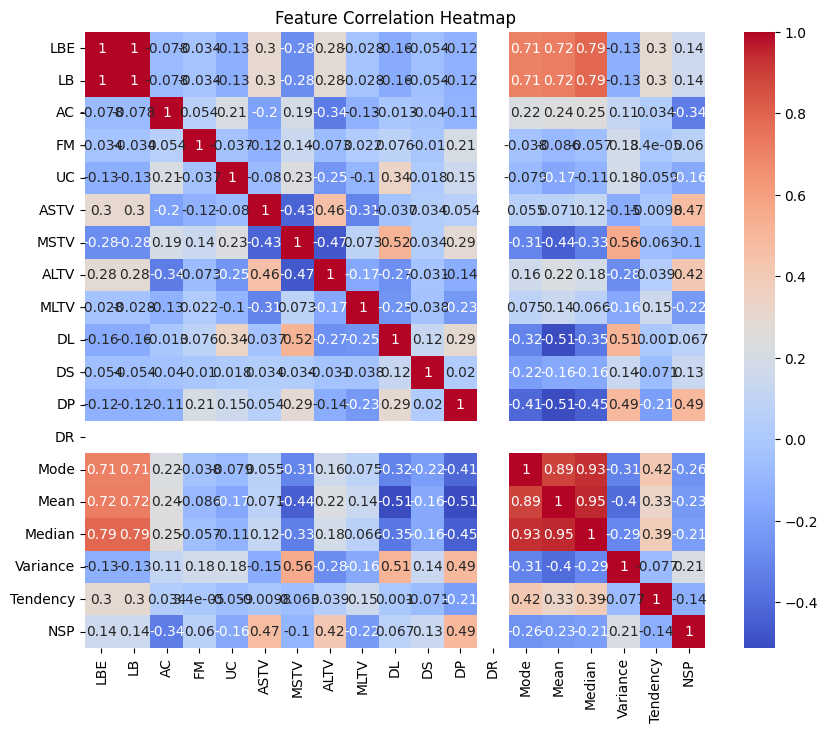

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,0.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,0.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,0.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [25]:
'''
features = ['LBE', 'Mean', 'MSTV', 'MLTV', 'Variance', 'NSP','DL','DS','DP','DR','AC','Mode','Median', 'Variance',
       'Tendency']
df = df[features]
'''
df = df.drop(columns=['Min', 'Max', 'Nmax', 'Nzeros', 'Width'])

print(df.columns)
print(df.shape)
df.info()

corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

display(df.head())

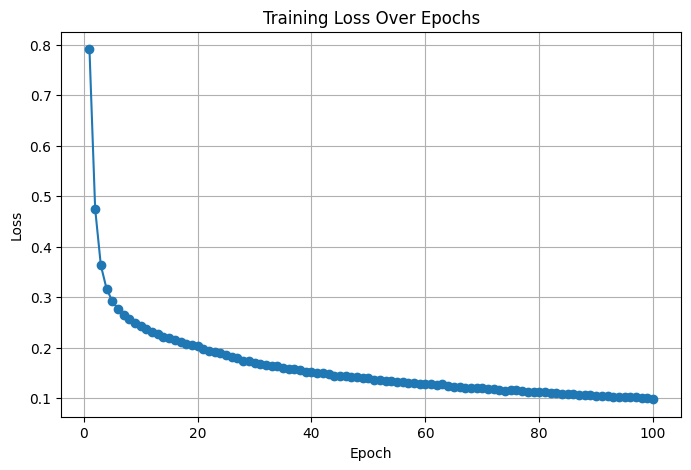

Accuracy: 0.9385
F1-score: 0.9378
ROC-AUC: 0.9875


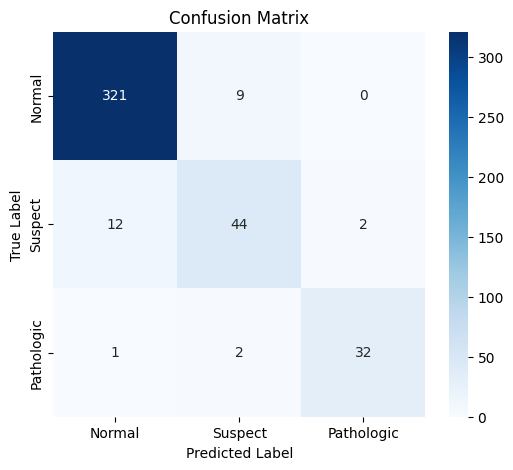

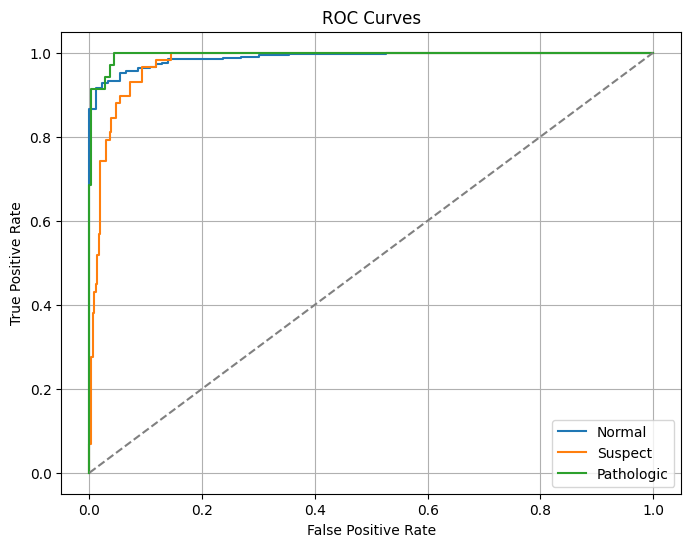

In [32]:
# модель без oversampling и взвешивания классов

# Разделяем данные
X = df.drop(columns=['NSP'])
y = df['NSP'].values - 1 # Приводим метки классов к диапазону [0, 1, 2]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели
class FetalHealthModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super(FetalHealthModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Функция обучения модели
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')
        losses.append(total_loss / len(train_loader))

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid()
    plt.show()

# Функция оценки модели и построения ROC-AUC
def evaluate_model(model, test_loader, class_labels):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(torch.softmax(outputs, dim=1).numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')

    # Построение матрицы ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Построение ROC-кривых для каждого класса
    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_true], [y[i] for y in y_scores])
        plt.plot(fpr, tpr, label=f'{class_labels[i]}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Инициализация модели
input_dim = X_train.shape[1]
model = FetalHealthModel(input_dim)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, train_loader, criterion, optimizer)

# Оценка модели
class_labels = {0: 'Normal', 1: 'Suspect', 2: 'Pathologic'}
evaluate_model(model, test_loader, class_labels)


In [39]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

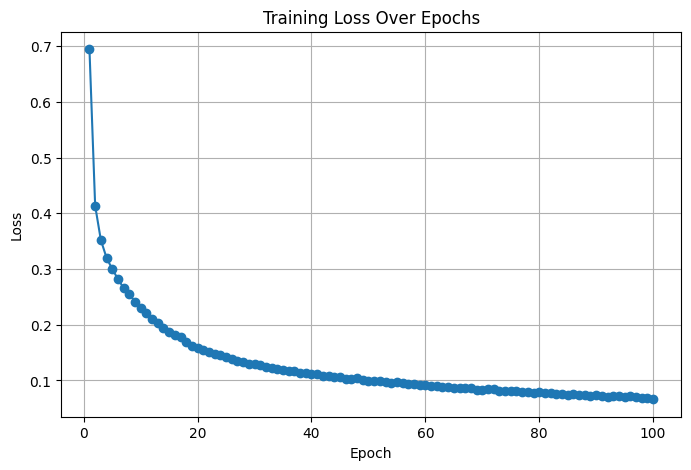

Accuracy: 0.9717
F1-score: 0.9716
ROC-AUC: 0.9964


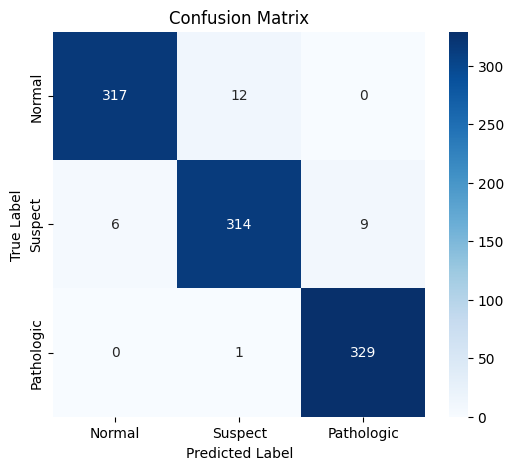

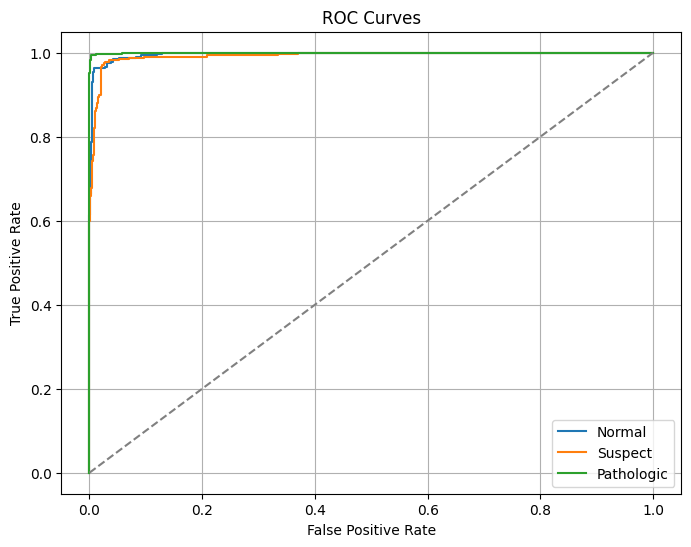

In [47]:
# модель с oversampling и взвешиванием классов

# Разделяем данные
X = df.drop(columns=['NSP'])
y = df['NSP'].values - 1 # Приводим метки классов к диапазону [0, 1, 2]

# Балансировка классов с помощью SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' балансирует все классы
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Нормализация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразуем данные в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели
class FetalHealthModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super(FetalHealthModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Функция обучения модели
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')
        losses.append(total_loss / len(train_loader))

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid()
    plt.show()

# Функция оценки модели и построения ROC-AUC
def evaluate_model(model, test_loader, class_labels):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())
            y_scores.extend(torch.softmax(outputs, dim=1).numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')

    # Построение матрицы ошибок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Построение ROC-кривых для каждого класса
    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_true], [y[i] for y in y_scores])
        plt.plot(fpr, tpr, label=f'{class_labels[i]}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Инициализация модели
input_dim = X_train.shape[1]
model = FetalHealthModel(input_dim)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, train_loader, criterion, optimizer)

# Оценка модели
class_labels = {0: 'Normal', 1: 'Suspect', 2: 'Pathologic'}
evaluate_model(model, test_loader, class_labels)
